## Load Data

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# Download AAPL data
data = yf.download("AAPL", start="2010-01-01", end="2024-01-01")

# Compute log returns
data["LogReturn"] = np.log(data["Close"] / data["Close"].shift(1))

# Add lagged log returns as features
for lag in range(1, 6):
    data[f"LogReturn_Lag{lag}"] = data["LogReturn"].shift(lag)

# Add percentage changes of other features
data["Open"] = data["Open"]
data["High"] = data["High"]
data["Low"] = data["Low"]
data["Close"] = data["Close"]
data["Volume"] = data["Volume"]

# Drop NaNs
data.dropna(inplace=True)

# Display prepared feature columns
print(data.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume LogReturn  \
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL             
Date                                                                      
2010-01-12  6.251043  6.312735  6.211921  6.295280  594459600 -0.011440   
2010-01-13  6.339215  6.347642  6.142103  6.255556  605892000  0.014007   
2010-01-14  6.302502  6.333498  6.290163  6.322966  432894000 -0.005808   
2010-01-15  6.197175  6.367806  6.195369  6.347642  594067600 -0.016853   
2010-01-19  6.471327  6.475841  6.236597  6.269399  730007600  0.043288   

Price      LogReturn_Lag1 LogReturn_Lag2 LogReturn_Lag3 LogReturn_Lag4  \
Ticker                                                                   
Date                                                                     
2010-01-12      -0.008860       0.006626      -0.001851      -0.016034   
2010-01-13      -0.011440      -0.008860       0.006626      -0.001851   
2010-01-14       0.014007    

In [ ]:
# Save as CSV and then read it -- this is silly and I will remove this unnecessary
# step. But for now, let's keep it (I first started with CSV but then switched to
# yfinance)
data.to_csv("data.csv")

data = pd.read_csv("data.csv", index_col=0, parse_dates=True)
data.head()

# Clean up metadata rows
data_clean = data.iloc[2:].copy()
data_clean.index.name = "Date"

# Convert index to datetime if not already
data_clean.index = pd.to_datetime(data_clean.index)

# Convert columns to numeric
for col in data_clean.columns:
    data_clean[col] = pd.to_numeric(data_clean[col], errors='coerce')

# Drop rows with missing values
data_clean.dropna(inplace=True)

# Confirm cleanup
data_clean.head()

<ipython-input-2-22eac2cbd6ff>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("data.csv", index_col=0, parse_dates=True)


,Close,High,Low,Open,Volume,LogReturn,LogReturn_Lag1,LogReturn_Lag2,LogReturn_Lag3,LogReturn_Lag4,LogReturn_Lag5
Date,,,,,,,,,,,
2010-01-12,6.251043,6.312735,6.211921,6.295280,594459600,-0.011440,-0.008860,0.006626,-0.001851,-0.016034,0.001727
2010-01-13,6.339215,6.347642,6.142103,6.255556,605892000,0.014007,-0.011440,-0.008860,0.006626,-0.001851,-0.016034
2010-01-14,6.302502,6.333498,6.290163,6.322966,432894000,-0.005808,0.014007,-0.011440,-0.008860,0.006626,-0.001851
2010-01-15,6.197175,6.367806,6.195369,6.347642,594067600,-0.016853,-0.005808,0.014007,-0.011440,-0.008860,0.006626
2010-01-19,6.471327,6.475841,6.236597,6.269399,730007600,0.043288,-0.016853,-0.005808,0.014007,-0.011440,-0.008860


## Train test split

In [ ]:
from sklearn.model_selection import train_test_split

# Define features and target
features = [
    "Open", "High", "Low", "Close", "Volume",
    "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3", "LogReturn_Lag4", "LogReturn_Lag5"
]
target = "LogReturn"

# Detrend the log return target (learn deviation from rolling mean)
rolling_window = 10
log_return = data_clean["LogReturn"]

# Compute excess return: log return minus rolling mean
data_clean["ExcessReturn"] = log_return - log_return.rolling(rolling_window).mean()

# Update the target column to use this new detrended version
target = "ExcessReturn"

X = data_clean[features]
y = data_clean[target]

# Split data by date ranges
X_train = X.loc["2010-01-01":"2020-12-31"]
y_train = y.loc["2010-01-01":"2020-12-31"]

X_val = X.loc["2021-01-01":"2022-12-31"]
y_val = y.loc["2021-01-01":"2022-12-31"]

X_test = X.loc["2023-01-01":"2023-12-31"]
y_test = y.loc["2023-01-01":"2023-12-31"]

# Display summary
{
    "Train shape": X_train.shape,
    "Validation shape": X_val.shape,
    "Test shape": X_test.shape,
    "Features": X.columns.tolist()
}


{'Train shape': (2763, 10),
 'Validation shape': (503, 10),
 'Test shape': (250, 10),
 'Features': ['Open',
  'High',
  'Low',
  'Close',
  'Volume',
  'LogReturn_Lag1',
  'LogReturn_Lag2',
  'LogReturn_Lag3',
  'LogReturn_Lag4',
  'LogReturn_Lag5']}

## Make model and train it

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train SVR with RBF kernel
svr = SVR(kernel='rbf', C=1.0, epsilon=0.001)
svr.fit(X_train_scaled, y_train)

# Predict on validation and test
y_val_pred = svr.predict(X_val_scaled)
y_test_pred = svr.predict(X_test_scaled)

# Display basic stats of predictions
{
    "Val Pred Mean": y_val_pred.mean(),
    "Val Pred Std": y_val_pred.std(),
    "Test Pred Mean": y_test_pred.mean(),
    "Test Pred Std": y_test_pred.std()
}


{'Val Pred Mean': np.float64(0.02829375226878398),
 'Val Pred Std': np.float64(0.02024804339535323),
 'Test Pred Mean': np.float64(0.02444813102632692),
 'Test Pred Std': np.float64(0.014239591520858373)}

## Backtest this model

In [ ]:
y_test_pred[-50:]

array([0.03266361, 0.03787265, 0.03579702, 0.04322444, 0.03679656,
       0.03891155, 0.03821906, 0.03848239, 0.02918299, 0.03917895,
       0.04374775, 0.01498775, 0.01470399, 0.02208391, 0.00494935,
       0.01284024, 0.01854031, 0.01226588, 0.00713846, 0.0154301 ,
       0.01040901, 0.01122299, 0.01406585, 0.01157525, 0.01059836,
       0.01378589, 0.01301795, 0.01477392, 0.0157137 , 0.01439851,
       0.0177046 , 0.01552181, 0.01188199, 0.01527816, 0.00654025,
       0.01113897, 0.01231402, 0.00871527, 0.01283627, 0.00653444,
       0.00738949, 0.01188692, 0.00853829, 0.00927547, 0.0092346 ,
       0.0134401 , 0.01251716, 0.01364113, 0.01410025, 0.01312054])

In [ ]:
import numpy as np

# Generate positions
threshold = 0.001
val_positions = np.where(y_val_pred > threshold, 1, np.where(y_val_pred < -threshold, -1, 0))
test_positions = np.where(y_test_pred > threshold, 1, np.where(y_test_pred < -threshold, -1, 0))

# Compute strategy returns
val_strategy_returns = val_positions * y_val.values
test_strategy_returns = test_positions * y_test.values

# Dollar returns with $1M starting capital
initial_capital = 1000000
val_dollar_returns = initial_capital * (np.exp(np.cumsum(val_strategy_returns)) - 1)
test_dollar_returns = initial_capital * (np.exp(np.cumsum(test_strategy_returns)) - 1)

# Cumulative return
val_cum_return = np.exp(np.cumsum(val_strategy_returns)) - 1
test_cum_return = np.exp(np.cumsum(test_strategy_returns)) - 1

# Sharpe ratio (annualized, assuming 252 trading days)
val_sharpe = np.mean(val_strategy_returns) / np.std(val_strategy_returns) * np.sqrt(252)
test_sharpe = np.mean(test_strategy_returns) / np.std(test_strategy_returns) * np.sqrt(252)

# Final return and sharpe
returns = {
    "Validation Cumulative Return": val_cum_return[-1],
    "Validation Sharpe Ratio": val_sharpe,
    "Test Cumulative Return": test_cum_return[-1],
    "Test Sharpe Ratio": test_sharpe
}

# Output final capital and profits for original model
capital = {
    "Final Val Capital": val_dollar_returns[-1] + initial_capital,
    "Final Test Capital": test_dollar_returns[-1] + initial_capital,
    "Total Val Profit": val_dollar_returns[-1],
    "Total Test Profit": test_dollar_returns[-1]
}

def print_formatted_metrics(returns, capital):
    """
    Print returns and capital metrics in a nicely formatted way.

    Parameters:
    - returns: Dictionary containing return and Sharpe ratio metrics
    - capital: Dictionary containing capital and profit metrics
    """
    print("----- PERFORMANCE METRICS -----\n")

    print("RETURNS")
    print(f"Validation Cumulative Return: {returns['Validation Cumulative Return']:.2%}")
    print(f"Validation Sharpe Ratio:      {returns['Validation Sharpe Ratio']:.4f}")
    print(f"Test Cumulative Return:       {returns['Test Cumulative Return']:.2%}")
    print(f"Test Sharpe Ratio:            {returns['Test Sharpe Ratio']:.4f}")

    print("\nCAPITAL")
    print(f"Final Val Capital:  ${capital['Final Val Capital']:,.2f}")
    print(f"Final Test Capital: ${capital['Final Test Capital']:,.2f}")
    print(f"Total Val Profit:   ${capital['Total Val Profit']:,.2f}")
    print(f"Total Test Profit:  ${capital['Total Test Profit']:,.2f}")

print_formatted_metrics(returns, capital)

----- PERFORMANCE METRICS -----

RETURNS
Validation Cumulative Return: 57.99%
Validation Sharpe Ratio:      0.7517
Test Cumulative Return:       53.05%
Test Sharpe Ratio:            2.1222

CAPITAL
Final Val Capital (Original):  $1,579,934.43
Final Test Capital (Original): $1,530,478.68
Total Val Profit (Original):   $579,934.43
Total Test Profit (Original):  $530,478.68


In [ ]:
test_pnl = initial_capital * (np.exp(test_positions * y_test.values) - 1)
average_pnl = np.mean(test_pnl)
print(f"Average PnL (with trade size $1MM):  ${average_pnl:,.2f}")
print("Average PnL percentage:"  f"  {average_pnl / initial_capital * 100:.2f}%")

Average PnL (with trade size $1MM):  $1,784.94
Average PnL percentage:  0.18%


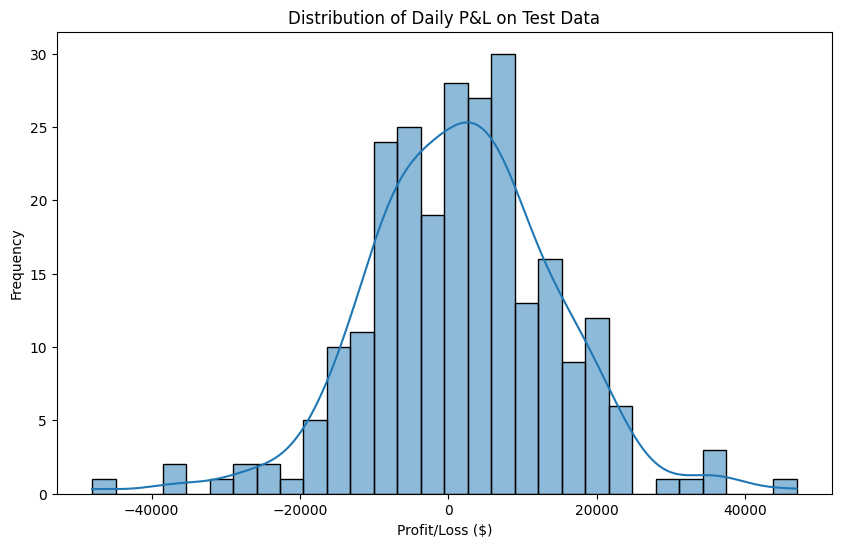

In [ ]:
# prompt: plot test_pnl in an easy to comprehend way. i want to see the distribution of profits vs loss

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'test_pnl' is defined as in the provided code

plt.figure(figsize=(10, 6))
sns.histplot(test_pnl, kde=True, bins=30)
plt.title('Distribution of Daily P&L on Test Data')
plt.xlabel('Profit/Loss ($)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Long/Short markers
long_signals = (test_positions == 1)
short_signals = (test_positions == -1)

# Get dates
test_dates = y_test.index

# Assume: prices is the actual price series for test window (2023)
P_t = X_test.Close[:-1]              # P_t for days 0 to N-2
r_hat_t_plus_1 = y_test_pred[1:]      # predicted log return for days 1 to N-1
P_hat_t_plus_1 = P_t * np.exp(r_hat_t_plus_1)  # predicted P_{t+1}


# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_dates, X_test.Close, label="Actual Price", alpha=0.7)
plt.plot(test_dates[-249:], P_hat_t_plus_1, label="Reconstructed Price from Predicted Returns", linestyle="--", alpha=0.7)
plt.scatter(test_dates[long_signals], X_test.Close.values[long_signals], marker='^', color='green', label='Long Entry', zorder=5)
plt.scatter(test_dates[short_signals], X_test.Close.values[short_signals], marker='v', color='red', label='Short Entry', zorder=5)
plt.title("AAPL 2023: Actual vs Reconstructed Price (from Predicted Log Returns)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()